# Notebook to gather and visualize data about all Osgoode Hall Law School faculty member research expertise

Requirements:
    
    !pip install pandas
    !pip install bs4
    !pip install openai
    !pip install requests
    !pip install wordcloud

Also requires [OpenAI account](https://openai.com/) and [OpenAI API key](https://platform.openai.com/account/api-keys). The key must be placed in a text file and pointed 
to in the setup cell (open_ai_inpath) below. Alternatively, store API key in os environment variable and use the commented out snippet in setup below.

License: [CC BY-NC 3.0](https://creativecommons.org/licenses/by-nc/3.0/)


### Setup

In [6]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import openai
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# set paths
json_outpath = 'data/Osgoode_faculty_bios.json'
open_ai_inpath = 'd:/ai-projects/secrets/SECRETS-OPENAI.txt'

# set OpenAI api key using secrets text file
with open(open_ai_inpath, 'r') as in_file:
    openai.api_key = in_file.readlines()[0]

# # set OpenAI api key using environment variable
# import os
# openai.api_key = os.environ['OPENAI_API_KEY']

### Scrape Osgoode website using requests and beautiful soup & load faculty bios into pandas dataframe

In [3]:
# Get all links for individual faculty members webpages

# load main faculty page
url = 'https://www.osgoode.yorku.ca/faculty/'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')

# get the main table on faculty page, convert to dataframe and clean
tables = soup.find_all('table')
df = pd.read_html(str(tables[0]))[0]
df.columns = df.columns.str.lower()
df.drop('unnamed: 0', axis=1, inplace=True)

# get all the links (hrefs) on faculty page
results = []
links = soup.find_all('a')
for link in links:
    if 'https://www.osgoode.yorku.ca/faculty-and-staff/' in link.get('href'):
        results.append(link.get('href'))

# delete every second link (b/c the links are duplicated)
results = results[::2]

# add links to the dataframe
df['href'] = results

df

,name,title,email,telephone,office,href
0,Rabiat Akande,Assistant Professor,rakande@osgoode.yorku.ca,416-650-8422,3048,https://www.osgoode.yorku.ca/faculty-and-staff...
1,Harry Arthurs,Professor Emeritus,harthurs@osgoode.yorku.ca,NaN,3015,https://www.osgoode.yorku.ca/faculty-and-staff...
2,Saptarishi Bandopadhyay,Associate Professor,sbandopadhyay@osgoode.yorku.ca,416-736-5488,4053,https://www.osgoode.yorku.ca/faculty-and-staff...
3,Stephanie Ben-Ishai,Professor and York University Distinguished Re...,sbenishai@osgoode.yorku.ca,416-650-8239,3043,https://www.osgoode.yorku.ca/faculty-and-staff...
4,Benjamin L. Berger,Professor & York Research Chair in Pluralism a...,bberger@osgoode.yorku.ca,416-736-5867,3030,https://www.osgoode.yorku.ca/faculty-and-staff...
...,...,...,...,...,...,...
73,Emily Kidd White,Assistant Professor,ekwhite@osgoode.yorku.ca,416-736-5826,3033,https://www.osgoode.yorku.ca/faculty-and-staff...
74,J. Scott Wilkie,Distinguished Professor of Practice,swilkie@osgoode.yorku.ca,416-736-2100 ext. 22189,4065,https://www.osgoode.yorku.ca/faculty-and-staff...
75,Cynthia Williams,Professor Emeritus,cwilliams@osgoode.yorku.ca,416-736-5545,4021,https://www.osgoode.yorku.ca/faculty-and-staff...
76,Alan N. Young,Professor Emeritus,ayoung@osgoode.yorku.ca,NaN,3015,https://www.osgoode.yorku.ca/faculty-and-staff...


In [4]:
# Scrape bios from individual faculty member webpages

# function to parse faculty member page
def parse_faculty_page(url):

    # load faculty member page
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')

    # get text from .entry-content tag
    bio = soup.find('div', {'class': 'entry-content'}).text
    bio = bio.replace('\xa0', ' ') # Remove non-breaking spaces
    bio = ' '.join(bio.split()) # Remove extra whitespace
    bio = bio.strip() # Remove leading and trailing whitespace

    # slow down process to avoid overloading server
    time.sleep(.5)
  
    return bio

# apply function to each row in dataframe
df['bio'] = df['href'].apply(parse_faculty_page) 

df


,name,title,email,telephone,office,href,bio
0,Rabiat Akande,Assistant Professor,rakande@osgoode.yorku.ca,416-650-8422,3048,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Rabiat Akande works in the fields of...
1,Harry Arthurs,Professor Emeritus,harthurs@osgoode.yorku.ca,NaN,3015,https://www.osgoode.yorku.ca/faculty-and-staff...,"University Professor, former Dean of Osgoode H..."
2,Saptarishi Bandopadhyay,Associate Professor,sbandopadhyay@osgoode.yorku.ca,416-736-5488,4053,https://www.osgoode.yorku.ca/faculty-and-staff...,I am an Associate Professor at Osgoode Hall La...
3,Stephanie Ben-Ishai,Professor and York University Distinguished Re...,sbenishai@osgoode.yorku.ca,416-650-8239,3043,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Stephanie Ben-Ishai is a Distinguish...
4,Benjamin L. Berger,Professor & York Research Chair in Pluralism a...,bberger@osgoode.yorku.ca,416-736-5867,3030,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Benjamin L. Berger is Professor and ...
...,...,...,...,...,...,...,...
73,Emily Kidd White,Assistant Professor,ekwhite@osgoode.yorku.ca,416-736-5826,3033,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Emily Kidd White’s areas of teaching...
74,J. Scott Wilkie,Distinguished Professor of Practice,swilkie@osgoode.yorku.ca,416-736-2100 ext. 22189,4065,https://www.osgoode.yorku.ca/faculty-and-staff...,"J. Scott Wilkie, a partner who practises in th..."
75,Cynthia Williams,Professor Emeritus,cwilliams@osgoode.yorku.ca,416-736-5545,4021,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Cynthia Williams joined Osgoode Hall...
76,Alan N. Young,Professor Emeritus,ayoung@osgoode.yorku.ca,NaN,3015,https://www.osgoode.yorku.ca/faculty-and-staff...,Alan Young is the Co-Founder and former Direct...


In [5]:
# Summarize faculty bios into research expertise keywords

# function to send prompt to GPT-3 and return completion
def get_completion(prompt, model_to_use):
    for attempt in range (5):
        try:
            model_output = openai.Completion.create(
            model=model_to_use,
            prompt=prompt,
            temperature= 0,
            max_tokens = 100,
            stop='\n')
            return model_output
        except:
            time.sleep(5)

# Send bio to GPT-3 and get keywords
model = 'text-davinci-003'
prompt_header = 'CONTEXT: The following text is a bio of a Faculty of Law faculty member. \n'\
'TASK: Based on the bio provide a list of up to 5 keywords that best describe the faculty member\'s '\
'main areas of research, separated by semi-colons. List the keywords in order of importance, with the most '\
'important keyword first. \n BIO: '
suffix_header = ' \nKEYWORDS:'

# iterate through the df and get the completions
for index, row in df.iterrows():
    bio = row['bio']
    bio = bio.split('Graduate Research Supervision (LLM, PhD):')[0]   # remove everything after 'Graduate Research Supervision (LLM, PhD):'
    bio = bio.replace('\n', ' ').strip()
    prompt = prompt_header + bio + suffix_header
    completion = get_completion(prompt, model).choices[0].text
    df.at[index, 'keywords'] = completion
    time.sleep(1) # slow down to avoid openai errors

# Save to json for future use
df.to_json(json_outpath, orient='records', indent = 2)

df

,name,title,email,telephone,office,href,bio,keywords
0,Rabiat Akande,Assistant Professor,rakande@osgoode.yorku.ca,416-650-8422,3048,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Rabiat Akande works in the fields of...,Law and Religion; Constitutional Law; Islamic...
1,Harry Arthurs,Professor Emeritus,harthurs@osgoode.yorku.ca,NaN,3015,https://www.osgoode.yorku.ca/faculty-and-staff...,"University Professor, former Dean of Osgoode H...",Legal Education; Legal Profession; Legal Hist...
2,Saptarishi Bandopadhyay,Associate Professor,sbandopadhyay@osgoode.yorku.ca,416-736-5488,4053,https://www.osgoode.yorku.ca/faculty-and-staff...,I am an Associate Professor at Osgoode Hall La...,Disasters; International Law; Environmental L...
3,Stephanie Ben-Ishai,Professor and York University Distinguished Re...,sbenishai@osgoode.yorku.ca,416-650-8239,3043,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Stephanie Ben-Ishai is a Distinguish...,Bankruptcy; Contract Law; Commercial Law; Fin...
4,Benjamin L. Berger,Professor & York Research Chair in Pluralism a...,bberger@osgoode.yorku.ca,416-736-5867,3030,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Benjamin L. Berger is Professor and ...,Law and Religion; Constitutional Law and Theo...
...,...,...,...,...,...,...,...,...
73,Emily Kidd White,Assistant Professor,ekwhite@osgoode.yorku.ca,416-736-5826,3033,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Emily Kidd White’s areas of teaching...,Legal and Political Philosophy; Constitutiona...
74,J. Scott Wilkie,Distinguished Professor of Practice,swilkie@osgoode.yorku.ca,416-736-2100 ext. 22189,4065,https://www.osgoode.yorku.ca/faculty-and-staff...,"J. Scott Wilkie, a partner who practises in th...",International Taxation; Corporate Taxation; T...
75,Cynthia Williams,Professor Emeritus,cwilliams@osgoode.yorku.ca,416-736-5545,4021,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Cynthia Williams joined Osgoode Hall...,Securities Law; Corporate Law; Corporate Resp...
76,Alan N. Young,Professor Emeritus,ayoung@osgoode.yorku.ca,NaN,3015,https://www.osgoode.yorku.ca/faculty-and-staff...,Alan Young is the Co-Founder and former Direct...,Criminal Law; Constitutional Challenges; Cons...


### Visualize faculty member research expertise keywords

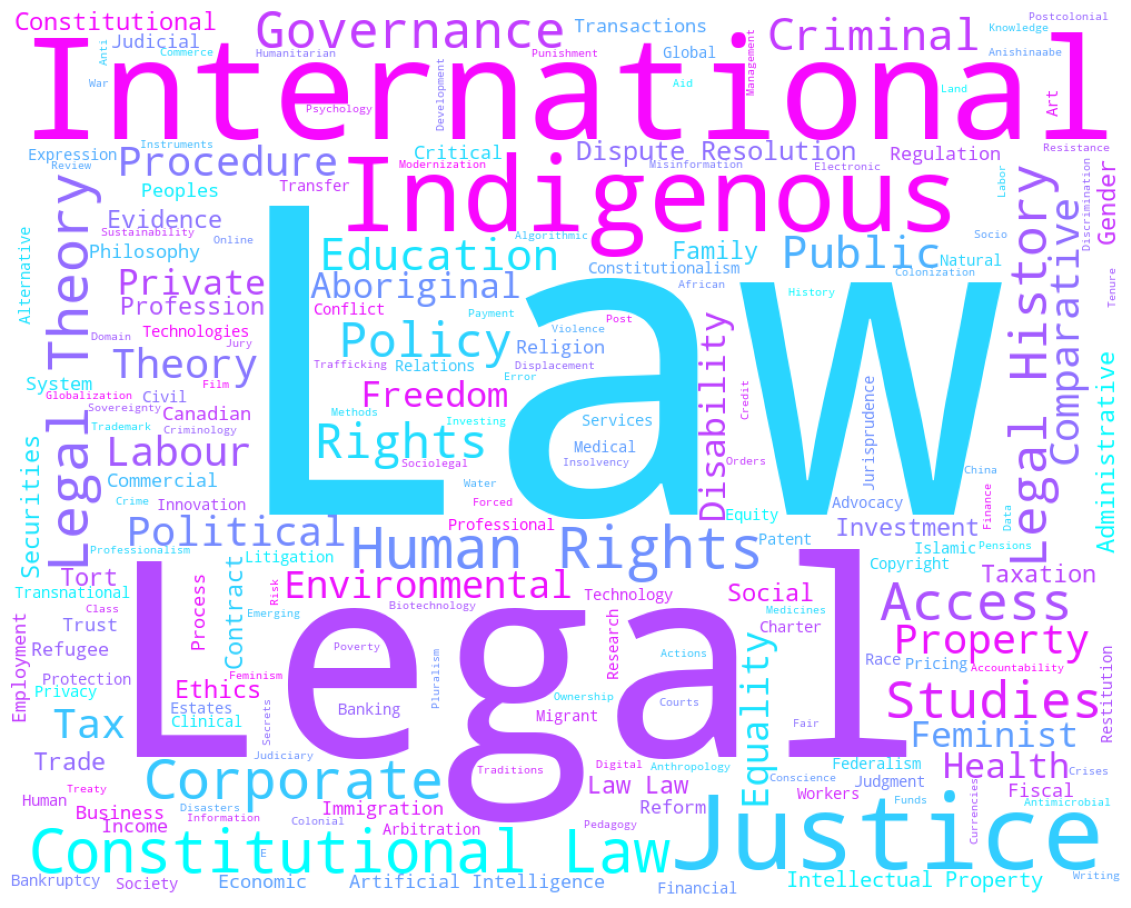

In [38]:
# Create word cloud of keywords

# create stopwords list
stopwords = [
    'Prize',
    'University',
    'Law School',
    'School of Law',
    'Osgoode',
    'Royal Society',
    'Research Council',
    'Centre'
]

# create list of keywords
keywords = []
for index, row in df.iterrows():
    phrases = row['keywords'].split(';')
    for phrase in phrases:
        phrase = phrase.replace('.', '')
        phrase = phrase.replace('/', ' and ')
        phrase = phrase.title()
        if not any(stopword in phrase for stopword in stopwords):
            keywords.append(phrase.strip())

text = '; '.join(keywords)

# Create a WordCloud object and generate the word cloud
colour_map = plt.cm.get_cmap('cool', 800)
wordcloud = WordCloud(width = 1000, height = 800,
                background_color = 'white',
                min_font_size = 10,
                colormap=colour_map).generate(text)

# Display the word cloud
plt.figure(figsize = (100,10), facecolor = 'white')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 4 )
plt.show()
